In [1]:
from pyspark.sql import SparkSession

# Crear sesión de Spark
spark = SparkSession.builder \
    .appName("Votantes Analysis") \
    .master("local[*]") \
    .getOrCreate()


25/01/02 18:04:47 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [2]:
# A CAMBIAR: Ruta del archivo
file_path = "/home/spark/Escritorio/datos_procesados/Spark/votantes_merged_29_12_2024_19_21.csv"

# Cargar el archivo CSV en un DataFrame de Spark
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Mostrar las primeras filas
df.show(5)


+---+-------------------+-------------+--------+----+---------+-------+-------------+------------+------+-----+-----------+
| id|         fecha_voto|       estado|   etnia|edad|     sexo|salario|     estudios|    religion|casado|hijos|       voto|
+---+-------------------+-------------+--------+----+---------+-------+-------------+------------+------+-----+-----------+
| 76|2024-01-28 00:00:00|     Oklahoma|   black|  37|masculino|  39354|undergraduate|       islam|  true|    4|republicano|
|589|2024-05-10 00:00:00|        Texas|   black|  91|masculino|  87377|      masters|       islam| false|    4|republicano|
|644|2024-05-05 00:00:00|     Oklahoma|hispanic|  75|masculino|  60316|       doctor|    hinduism|  true|    4|republicano|
|659|2024-04-03 00:00:00|West Virginia|hispanic|  22| femenino| 236552|     graduate|     atheism| false|    0|  democrata|
|159|2024-01-05 00:00:00|     Oklahoma|   black|  36| femenino| 129401|       doctor|christianism| false|    5|  democrata|
+---+---

In [3]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- fecha_voto: timestamp (nullable = true)
 |-- estado: string (nullable = true)
 |-- etnia: string (nullable = true)
 |-- edad: integer (nullable = true)
 |-- sexo: string (nullable = true)
 |-- salario: integer (nullable = true)
 |-- estudios: string (nullable = true)
 |-- religion: string (nullable = true)
 |-- casado: boolean (nullable = true)
 |-- hijos: integer (nullable = true)
 |-- voto: string (nullable = true)



In [6]:
df.describe(["edad", "salario", "hijos"]).show()

+-------+------------------+-----------------+------------------+
|summary|              edad|          salario|             hijos|
+-------+------------------+-----------------+------------------+
|  count|              2000|             2000|              2000|
|   mean|           54.1655|      139404.2115|             2.559|
| stddev|23.467093172802418|63193.69966138408|1.6979282906648654|
|    min|                10|            30075|                 0|
|    max|                98|           249796|                 5|
+-------+------------------+-----------------+------------------+



In [8]:
from pyspark.sql.functions import col 

total_votos = df.count()
df.groupBy("voto").count().withColumn("porcentaje", (col("count") / total_votos) * 100).show()

+-----------+-----+----------+
|       voto|count|porcentaje|
+-----------+-----+----------+
|  democrata|  998|      49.9|
|republicano| 1002|      50.1|
+-----------+-----+----------+



In [9]:
df.groupBy("voto").avg("salario").withColumnRenamed("avg(salario)", "salario_promedio").show()


+-----------+------------------+
|       voto|  salario_promedio|
+-----------+------------------+
|  democrata| 139658.8597194389|
|republicano|139150.57984031935|
+-----------+------------------+



In [11]:
df.groupBy("estado", "voto").count().orderBy("estado").show(n=100, truncate=False)

+--------------+-----------+-----+
|estado        |voto       |count|
+--------------+-----------+-----+
|Alabama       |republicano|27   |
|Alabama       |democrata  |6    |
|Alaska        |republicano|23   |
|Alaska        |democrata  |21   |
|Arizona       |democrata  |24   |
|Arizona       |republicano|23   |
|Arkansas      |democrata  |11   |
|Arkansas      |republicano|29   |
|California    |democrata  |27   |
|Colorado      |republicano|21   |
|Colorado      |democrata  |16   |
|Connecticut   |democrata  |37   |
|Connecticut   |republicano|6    |
|Delaware      |republicano|6    |
|Delaware      |democrata  |23   |
|Florida       |democrata  |7    |
|Florida       |republicano|36   |
|Georgia       |democrata  |17   |
|Georgia       |republicano|25   |
|Hawaii        |republicano|5    |
|Hawaii        |democrata  |22   |
|Idaho         |democrata  |6    |
|Idaho         |republicano|36   |
|Illinois      |democrata  |22   |
|Illinois      |republicano|3    |
|Indiana       |repu

In [13]:
df.groupBy("voto", "estudios").count().orderBy(["voto", "estudios"], ascending=[True, True]).show()

+-----------+-------------+-----+
|       voto|     estudios|count|
+-----------+-------------+-----+
|  democrata|       doctor|  299|
|  democrata|     graduate|  163|
|  democrata|  high school|   69|
|  democrata|      masters|  325|
|  democrata|undergraduate|  142|
|republicano|       doctor|  126|
|republicano|     graduate|  245|
|republicano|  high school|  299|
|republicano|      masters|  116|
|republicano|undergraduate|  216|
+-----------+-------------+-----+



In [16]:
from pyspark.sql.functions import avg, min, max

df.groupBy("voto").agg(
    avg("edad").alias("edad_promedio"),
    min("edad").alias("edad_minima"),
    max("edad").alias("edad_maxima")
).show()


+-----------+------------------+-----------+-----------+
|       voto|     edad_promedio|edad_minima|edad_maxima|
+-----------+------------------+-----------+-----------+
|  democrata| 46.59719438877755|         10|         98|
|republicano|61.703592814371255|         10|         98|
+-----------+------------------+-----------+-----------+



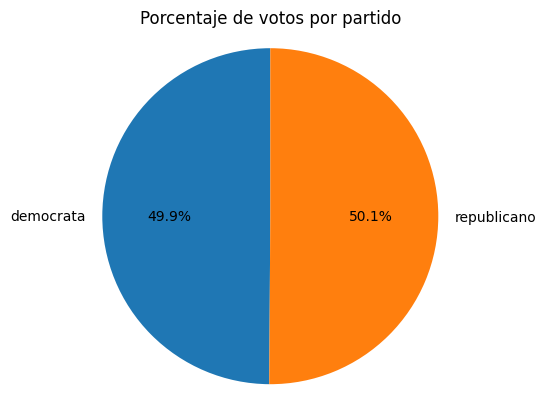

In [18]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Obtener el porcentaje de votos
votos_porcentaje = df.groupBy("voto").count().withColumn("porcentaje", (col("count") / total_votos) * 100).toPandas()

# Crear la gráfica de pastel
plt.pie(votos_porcentaje["porcentaje"], labels=votos_porcentaje["voto"], autopct='%1.1f%%', startangle=90)
plt.title("Porcentaje de votos por partido")
plt.axis("equal")  # Asegura que el gráfico sea un círculo perfecto
plt.show()spark@linuxserver2324:~$ pip install matplotlib


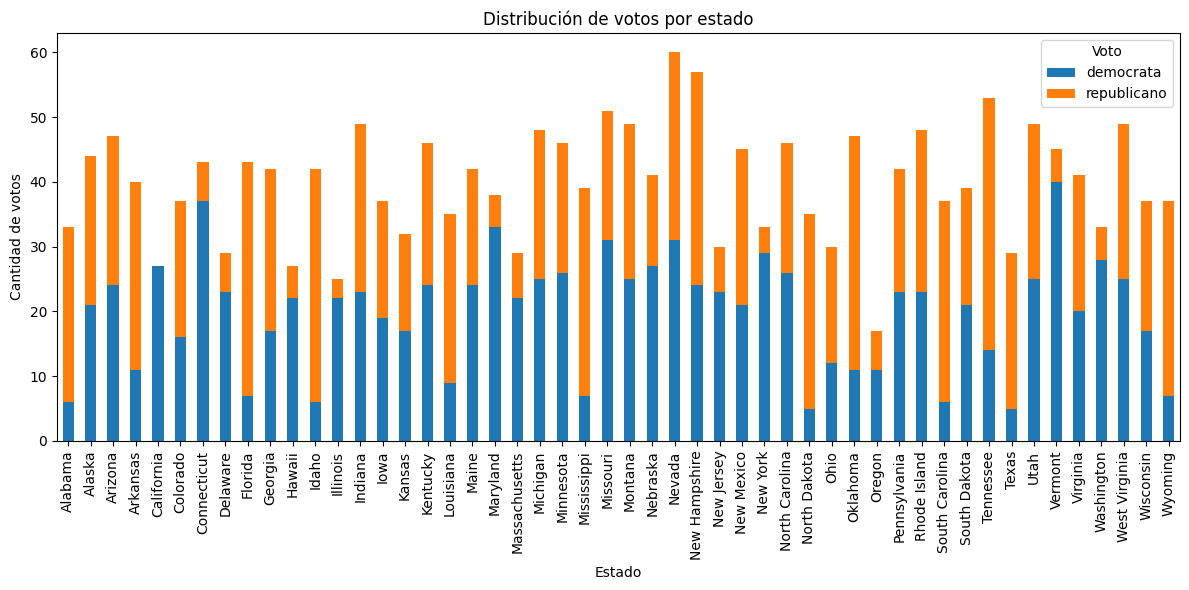

In [19]:
# Obtener los datos agrupados por estado y voto
votos_estado = df.groupBy("estado", "voto").count().toPandas()

# Crear un gráfico de barras apiladas
votos_estado.pivot(index="estado", columns="voto", values="count").plot(
    kind="bar", stacked=True, figsize=(12, 6)
)
plt.title("Distribución de votos por estado")
plt.xlabel("Estado")
plt.ylabel("Cantidad de votos")
plt.legend(title="Voto")
plt.tight_layout()
plt.show()


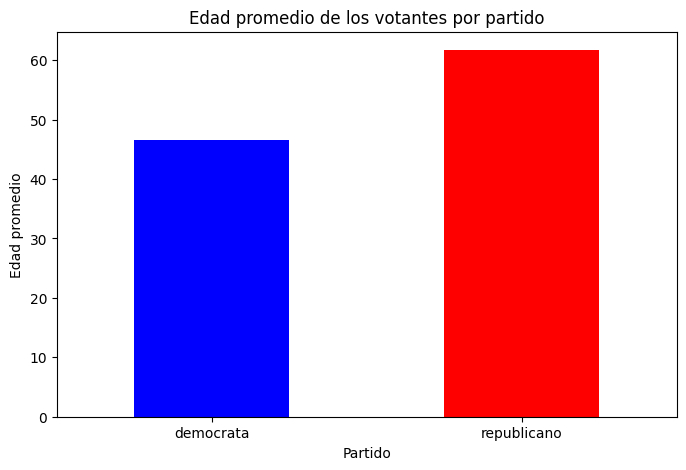

In [21]:
# Calcular la edad promedio por partido
edad_promedio = df.groupBy("voto").agg(avg("edad").alias("edad_promedio")).toPandas()

# Crear un gráfico de barras
edad_promedio.plot(
    x="voto", y="edad_promedio", kind="bar", legend=False, color=["blue", "red"], figsize=(8, 5)
)
plt.title("Edad promedio de los votantes por partido")
plt.xlabel("Partido")
plt.ylabel("Edad promedio")
plt.xticks(rotation=0)
plt.show()


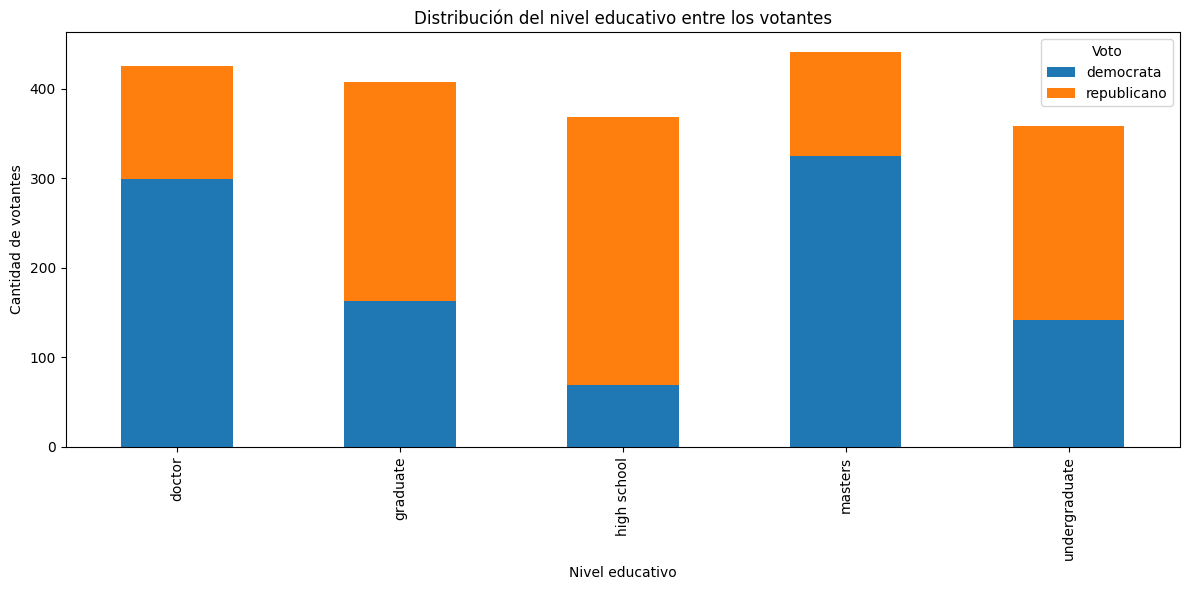

In [22]:
# Obtener los datos agrupados por nivel educativo y partido
educacion_voto = df.groupBy("estudios", "voto").count().toPandas()

# Crear un gráfico de barras apiladas
educacion_voto.pivot(index="estudios", columns="voto", values="count").plot(
    kind="bar", stacked=True, figsize=(12, 6)
)
plt.title("Distribución del nivel educativo entre los votantes")
plt.xlabel("Nivel educativo")
plt.ylabel("Cantidad de votantes")
plt.legend(title="Voto")
plt.tight_layout()
plt.show()


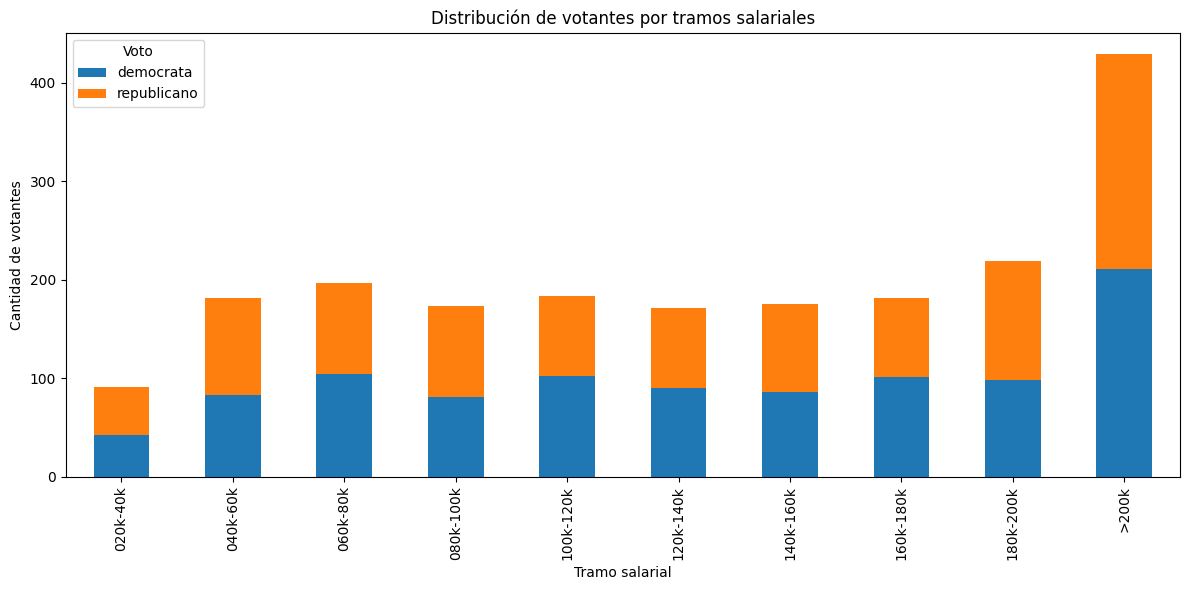

In [26]:
from pyspark.sql.functions import col, when

# Crear una columna con tramos salariales hasta 200k
df = df.withColumn(
    "tramo_salarial",
    when(col("salario") < 20000, "<20k")
    .when((col("salario") >= 20000) & (col("salario") < 40000), "020k-40k")
    .when((col("salario") >= 40000) & (col("salario") < 60000), "040k-60k")
    .when((col("salario") >= 60000) & (col("salario") < 80000), "060k-80k")
    .when((col("salario") >= 80000) & (col("salario") < 100000), "080k-100k")
    .when((col("salario") >= 100000) & (col("salario") < 120000), "100k-120k")
    .when((col("salario") >= 120000) & (col("salario") < 140000), "120k-140k")
    .when((col("salario") >= 140000) & (col("salario") < 160000), "140k-160k")
    .when((col("salario") >= 160000) & (col("salario") < 180000), "160k-180k")
    .when((col("salario") >= 180000) & (col("salario") <= 200000), "180k-200k")
    .when(col("salario") > 200000, ">200k")
)

# Agrupar por tramo salarial y voto
tramos_salariales = df.groupBy("tramo_salarial", "voto").count().orderBy("tramo_salarial").toPandas()

# Crear el gráfico
tramos_salariales.pivot(index="tramo_salarial", columns="voto", values="count").plot(
    kind="bar", stacked=True, figsize=(12, 6)
)
plt.title("Distribución de votantes por tramos salariales")
plt.xlabel("Tramo salarial")
plt.ylabel("Cantidad de votantes")
plt.legend(title="Voto")
plt.tight_layout()
plt.show()


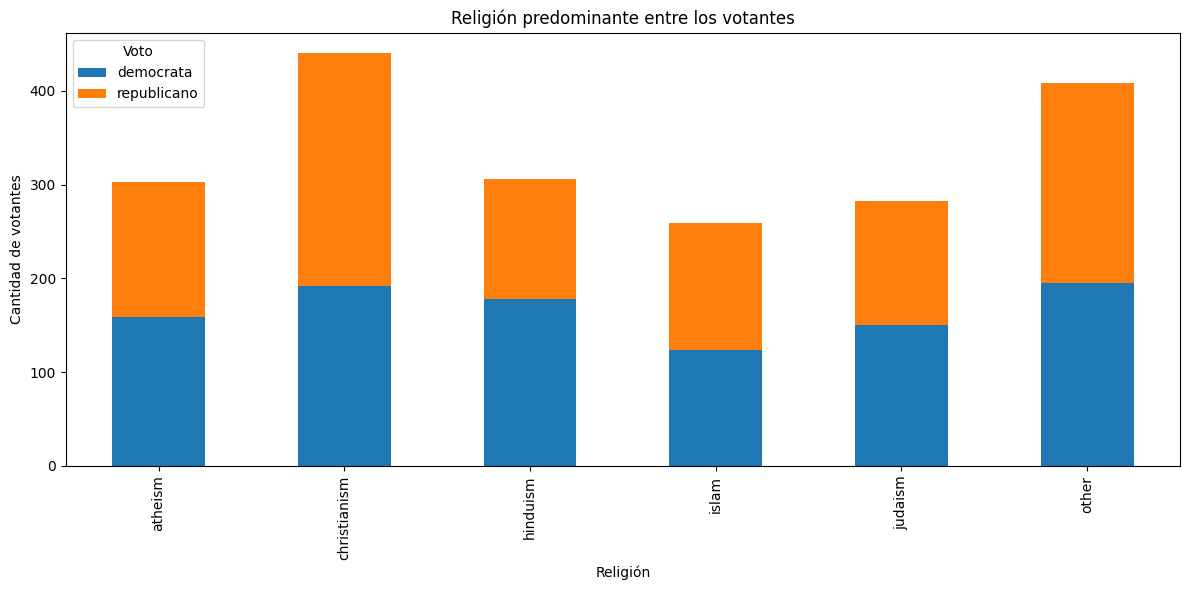

In [27]:
# Obtener los datos agrupados por religión y partido
religion_voto = df.groupBy("religion", "voto").count().toPandas()

# Crear un gráfico de barras apiladas
religion_voto.pivot(index="religion", columns="voto", values="count").plot(
    kind="bar", stacked=True, figsize=(12, 6)
)
plt.title("Religión predominante entre los votantes")
plt.xlabel("Religión")
plt.ylabel("Cantidad de votantes")
plt.legend(title="Voto")
plt.tight_layout()
plt.show()


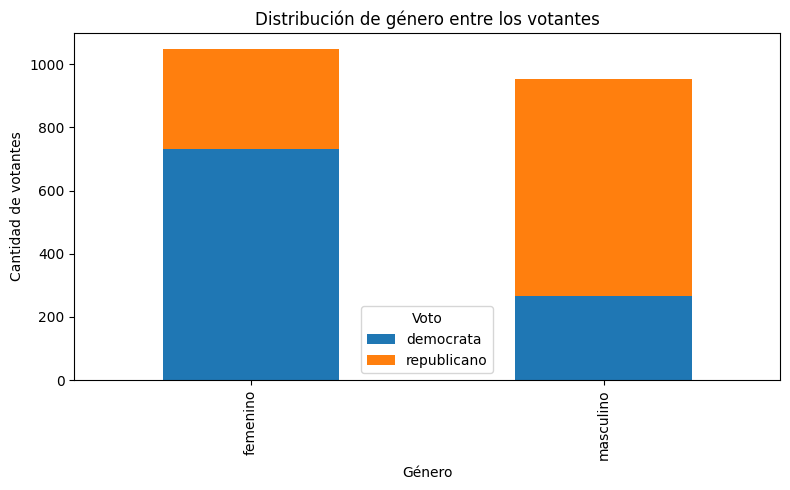

In [28]:
# Obtener los datos agrupados por género y partido
genero_voto = df.groupBy("sexo", "voto").count().toPandas()

# Crear un gráfico de barras apiladas
genero_voto.pivot(index="sexo", columns="voto", values="count").plot(
    kind="bar", stacked=True, figsize=(8, 5)
)
plt.title("Distribución de género entre los votantes")
plt.xlabel("Género")
plt.ylabel("Cantidad de votantes")
plt.legend(title="Voto")
plt.tight_layout()
plt.show()


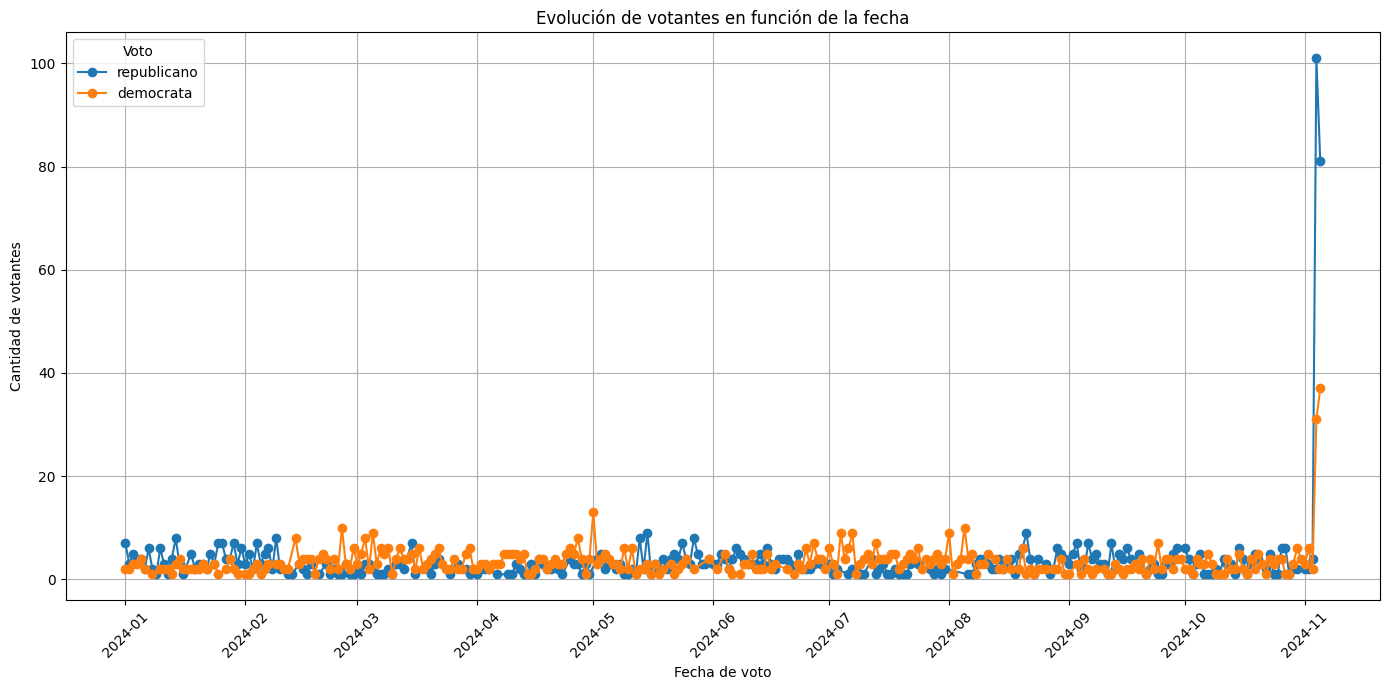

In [29]:
from pyspark.sql.functions import to_date, col
import matplotlib.pyplot as plt

# Convertir la columna 'fecha_voto' a formato de fecha
df = df.withColumn("fecha_voto", to_date(col("fecha_voto")))

# Agrupar por fecha y voto
votantes_por_fecha = df.groupBy("fecha_voto", "voto").count().orderBy("fecha_voto").toPandas()

# Crear el gráfico
plt.figure(figsize=(14, 7))
for voto in votantes_por_fecha["voto"].unique():
    data = votantes_por_fecha[votantes_por_fecha["voto"] == voto]
    plt.plot(data["fecha_voto"], data["count"], marker='o', label=voto)

plt.title("Evolución de votantes en función de la fecha")
plt.xlabel("Fecha de voto")
plt.ylabel("Cantidad de votantes")
plt.legend(title="Voto")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


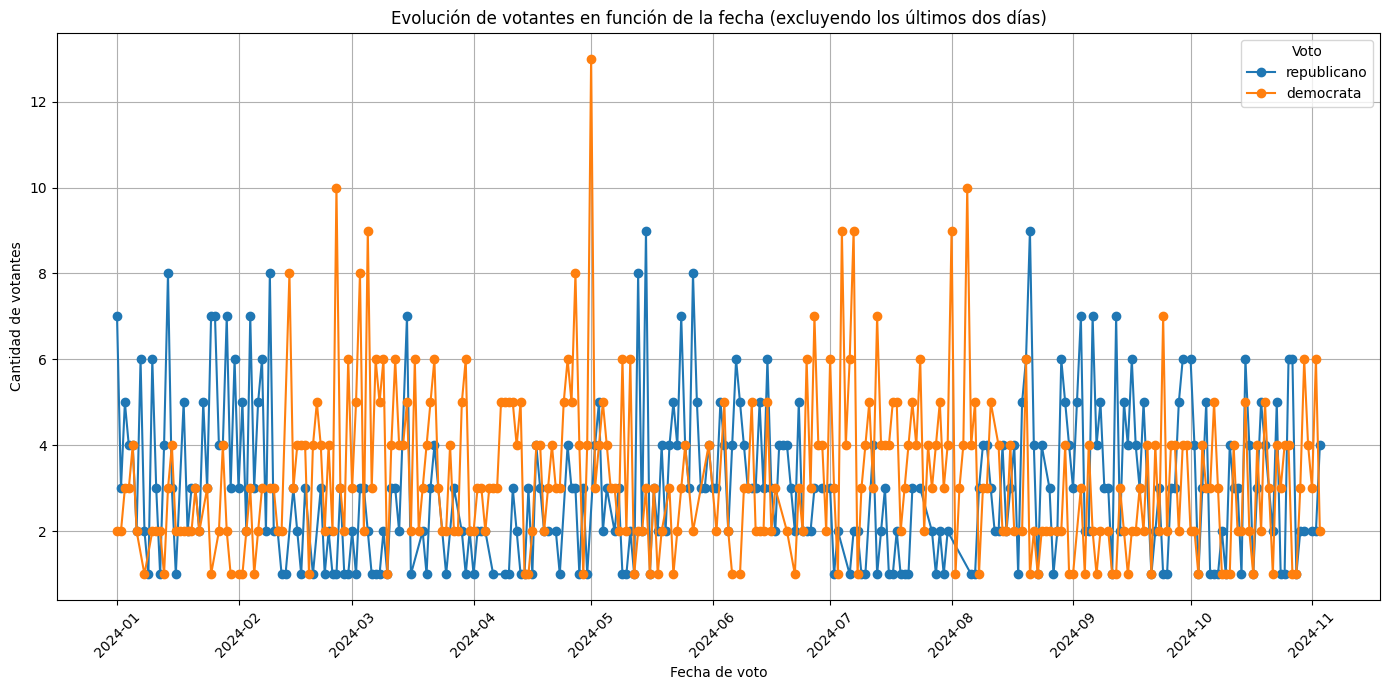

In [30]:
from pyspark.sql.functions import to_date, col, desc

# Convertir la columna 'fecha_voto' a formato de fecha
df = df.withColumn("fecha_voto", to_date(col("fecha_voto")))

# Identificar las dos fechas más recientes
fechas_recientes = df.select("fecha_voto").distinct().orderBy(desc("fecha_voto")).limit(2).toPandas()["fecha_voto"].tolist()

# Filtrar las filas que no correspondan a las dos últimas fechas
df_filtrado = df.filter(~col("fecha_voto").isin(fechas_recientes))

# Agrupar por fecha y voto
votantes_por_fecha = df_filtrado.groupBy("fecha_voto", "voto").count().orderBy("fecha_voto").toPandas()

# Crear el gráfico
plt.figure(figsize=(14, 7))
for voto in votantes_por_fecha["voto"].unique():
    data = votantes_por_fecha[votantes_por_fecha["voto"] == voto]
    plt.plot(data["fecha_voto"], data["count"], marker='o', label=voto)

plt.title("Evolución de votantes en función de la fecha (excluyendo los últimos dos días)")
plt.xlabel("Fecha de voto")
plt.ylabel("Cantidad de votantes")
plt.legend(title="Voto")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
